In [5]:
import numpy as np 
import pandas as pd 
import plotly.express as px  
import xgboost as xgb
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.compose import *
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
print(xgb.__version__)
import sklearn
print(sklearn.__version__)
import os

import warnings
warnings.filterwarnings("ignore")


2.1.3
1.6.0


In [6]:
# Reading the input 
data_train = train_data =pd.read_csv("store-sales-time-series-forecasting/train.csv")
data_test = test_data =pd.read_csv("store-sales-time-series-forecasting/test.csv")
data_oil = oil_data = pd.read_csv("store-sales-time-series-forecasting/oil.csv")
data_stores = stores_data = pd.read_csv("store-sales-time-series-forecasting/stores.csv")
data_holidays = holidays_data = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
data_transactions = pd.read_csv("store-sales-time-series-forecasting/transactions.csv")

In [7]:
print( train_data.shape )
train_data

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [8]:
# Convert the date column to a datetime type
train_data["date"]= pd.to_datetime( train_data["date"] )
print(train_data.isnull().sum())
print()
# Sales ka distribution dekhna
print(train_data['sales'].describe())

# Unique stores aur product families count karna
print("Unique Stores:", train_data['store_nbr'].nunique())
print("Unique Product Families:", train_data['family'].nunique())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64
Unique Stores: 54
Unique Product Families: 33


In [9]:
# Converting date columns to datetime format
for df in [oil_data, holidays_data, train_data, test_data, data_transactions]:
    df['date'] = pd.to_datetime(df['date'])

# Filter training data to include only rows after 2013-01-01
train_data = train_data[train_data['date'] > '2013-01-01']

In [10]:
# Function to plot graphs
def plot_chart(data, kind, title, xlabel, ylabel, color=None, figsize=(12, 6)):
    data.plot(kind=kind, figsize=figsize, color=color, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    print()


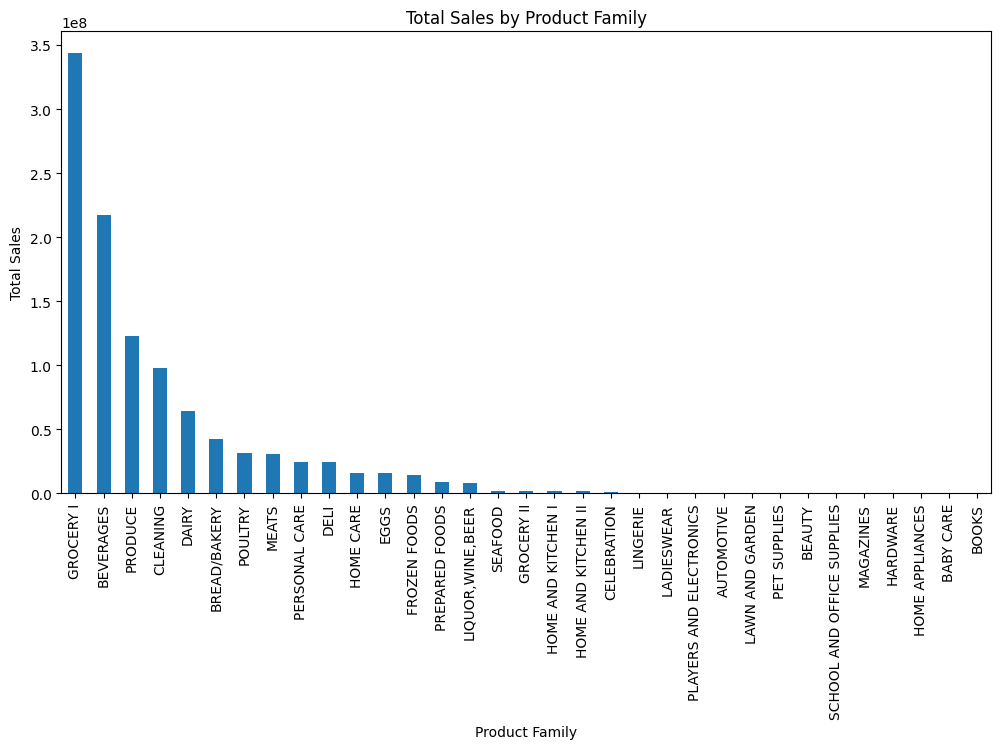

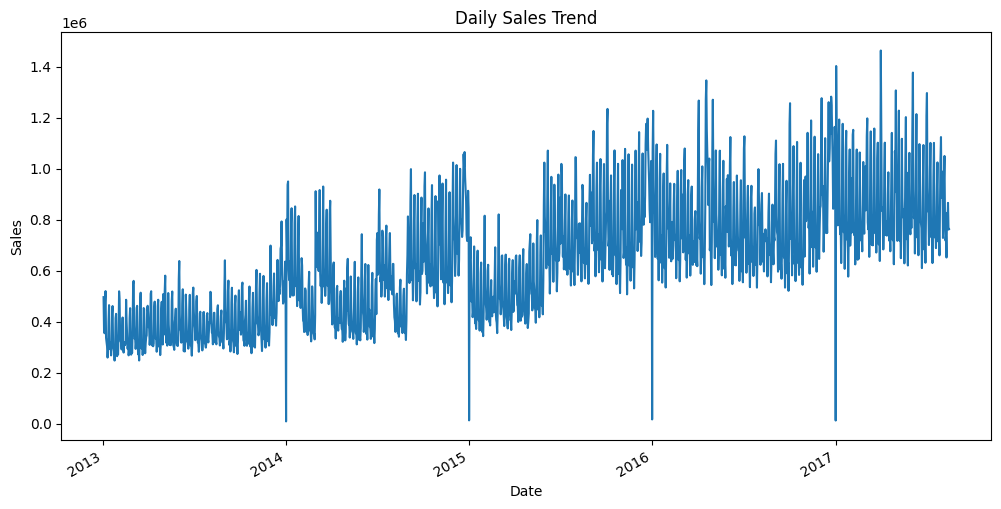

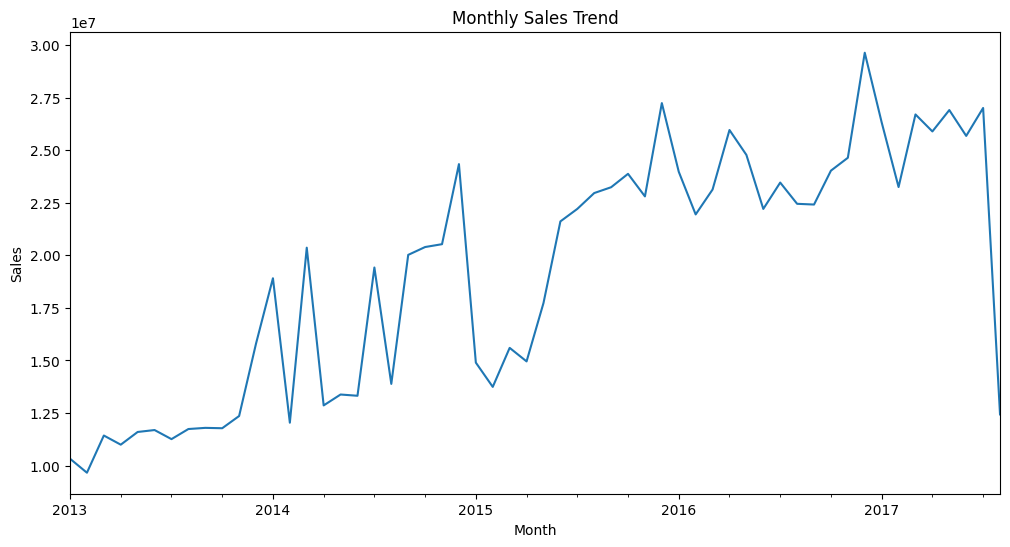

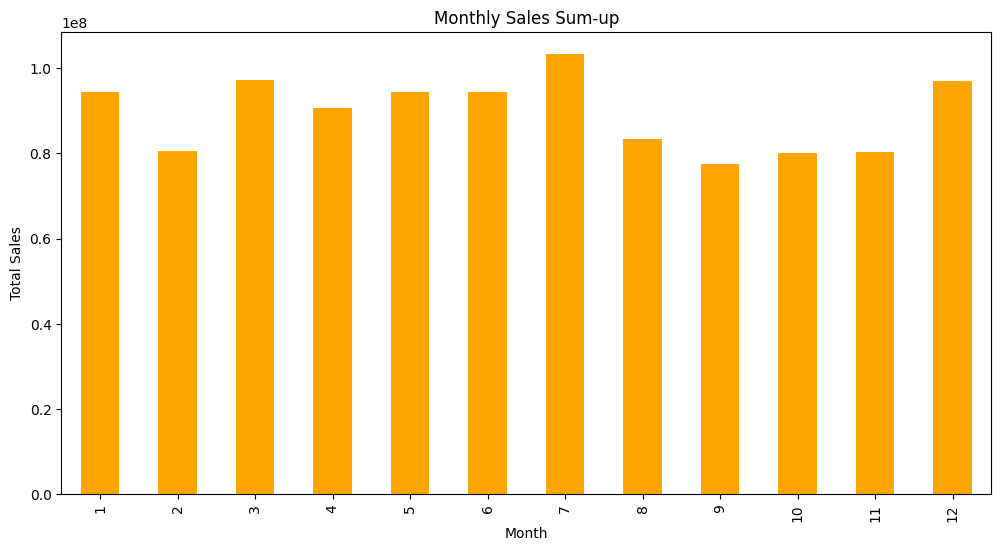

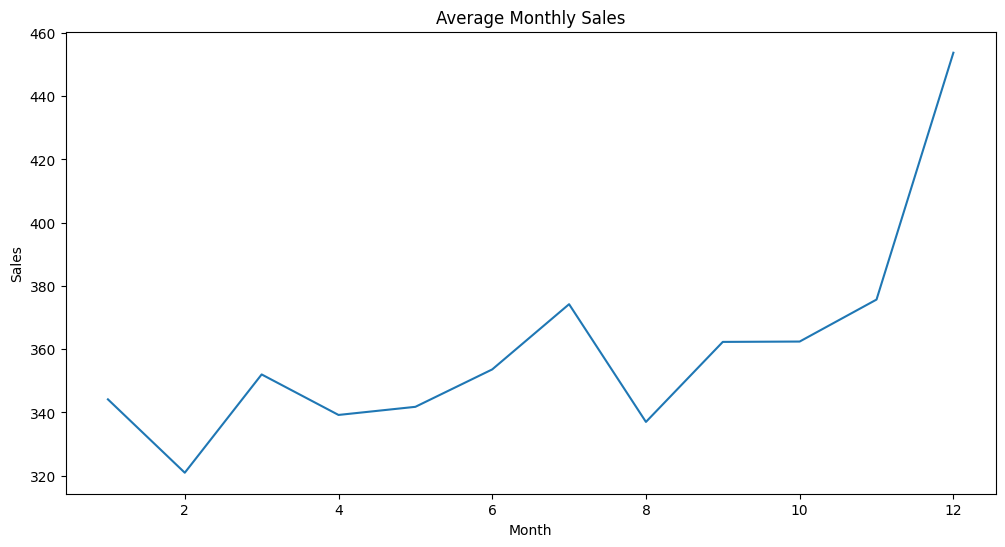

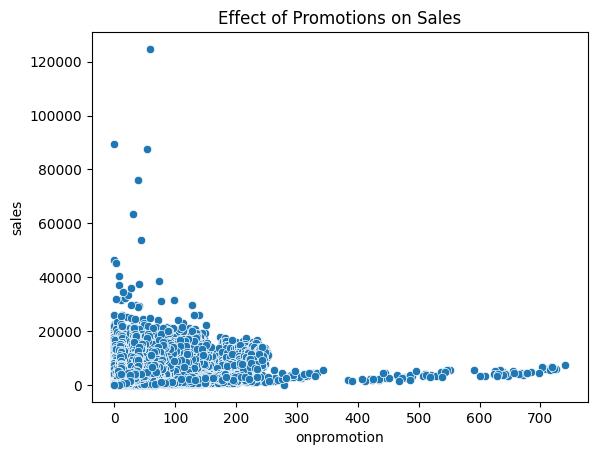

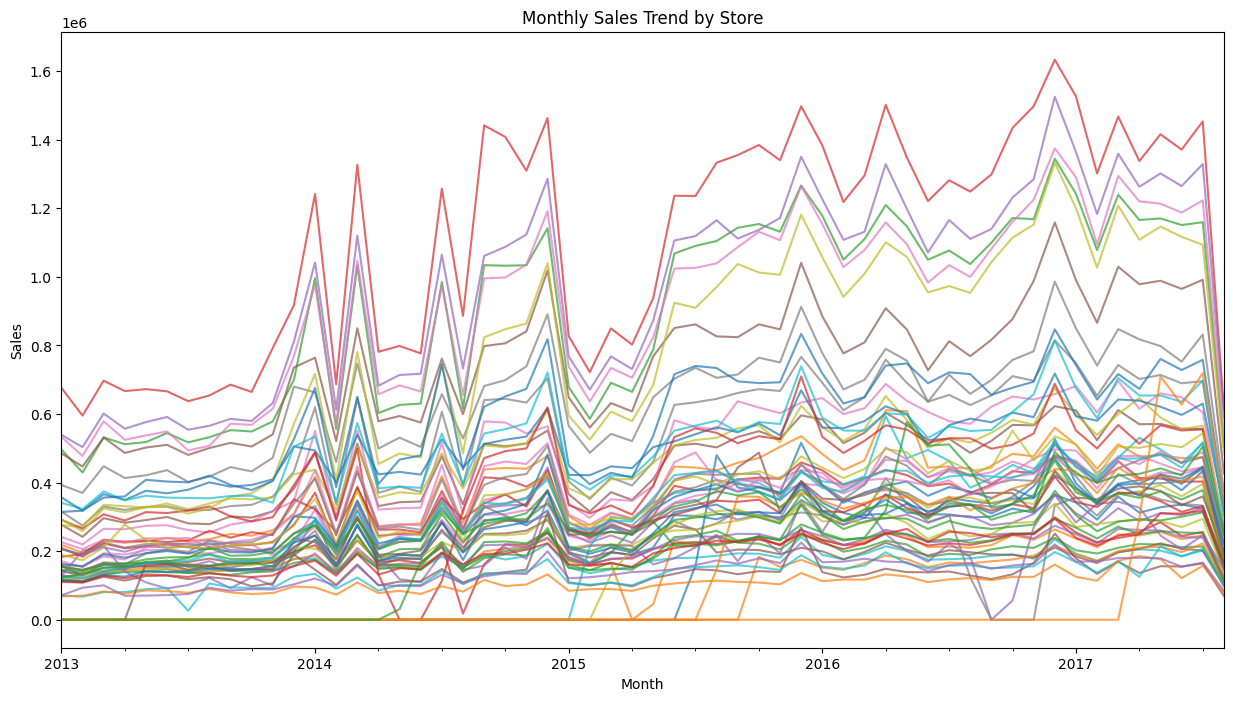

In [11]:
# Total sales by product family
family_sales = train_data.groupby('family')['sales'].sum().sort_values(ascending=False)
plot_chart(family_sales, 'bar', 'Total Sales by Product Family', 'Product Family', 'Total Sales')

# Daily sales trend
daily_sales = train_data.groupby('date')['sales'].sum()
plot_chart(daily_sales, 'line', 'Daily Sales Trend', 'Date', 'Sales')

# Monthly sales trend
monthly_sales = train_data.groupby(train_data['date'].dt.to_period('M'))['sales'].sum()
plot_chart(monthly_sales, 'line', 'Monthly Sales Trend', 'Month', 'Sales')

# Monthly sales by bar plot
monthly_sales_by_month = train_data.groupby(train_data['date'].dt.month)['sales'].sum()
plot_chart(monthly_sales_by_month, 'bar', 'Monthly Sales Sum-up', 'Month', 'Total Sales', color='orange')

# Average monthly sales
monthly_avg_sales = train_data.groupby(train_data['date'].dt.month)['sales'].mean()
plot_chart(monthly_avg_sales, 'line', 'Average Monthly Sales', 'Month', 'Sales')

# Effect of promotions on sales
sns.scatterplot(data=train_data, x='onpromotion', y='sales')
plt.title("Effect of Promotions on Sales")
plt.show()

# Monthly sales trend by store
store_sales = train_data.groupby(['store_nbr', train_data['date'].dt.to_period('M')])['sales'].sum().unstack()
store_sales.T.plot(figsize=(15, 8), legend=False, alpha=0.7, title="Monthly Sales Trend by Store")
plt.ylabel('Sales')
plt.xlabel('Month')
plt.show()

In [12]:

holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


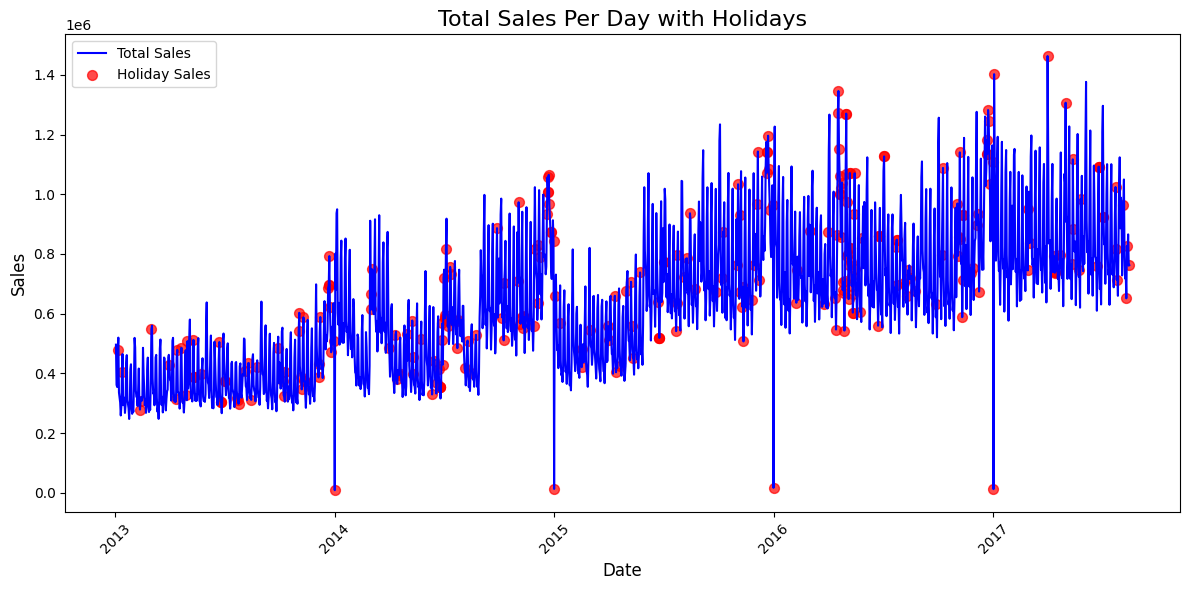

In [13]:
import matplotlib.pyplot as plt

# Group data by date and calculate the total sales for each day
total_sales = train_data[["sales", "date"]].groupby("date").sum().reset_index()

# Join the holidays with the total sales
holidays = holidays_data.merge(total_sales, on="date", how="left")

# Plot the total sales as a line plot
plt.figure(figsize=(12, 6))
plt.plot(total_sales["date"], total_sales["sales"], label="Total Sales", color="blue")

# Highlight holidays with scatter points
plt.scatter(holidays["date"], holidays["sales"], color="red", label="Holiday Sales", s=50, alpha=0.7)

# Add titles and labels
plt.title("Total Sales Per Day with Holidays", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
def process_data(df : pd.DataFrame, is_test = False):
    # coulumns that we want to keep
    col_train = [ 'date', 'family', 'onpromotion', 'sales', 'store_nbr', 'id']
    col_test = [ 'date', 'family', 'onpromotion', 'store_nbr', 'id']
    col_holidays = ['date', 'type', 'transferred']

    if is_test:
        col_df = col_test
    else:
        col_df = col_train
    
    # merge to form our dataset
    df = df[col_df].merge(data_oil,'left','date').merge(data_holidays[col_holidays],'left', 'date').rename(columns={'type': 'day_type', 'dcoilwtico' : 'crude_price'})

    df['day_type'] = df['day_type'].fillna('Work Day')
    df['transferred'] = df['transferred'].fillna(False)

    # only keep holidays that are not transferred. i.e true holidays
    df['is_holiday'] = np.where(
        (df['day_type'] == 'Work Day'), 0,
        np.where(
            (df['day_type'].isin(['Holiday', 'Additional', 'Event', 'Transfer', 'Bridge'])) &
            (df['transferred'] == False),
            1,
            0
        )
    )
    
    # where onpromotion is 0.0 change it to 0 else 1
    df['onpromotion'] = np.where(df['onpromotion'] == 0.0, 0, 1)
    
    # new column with index starting from 1 if date is same then keep
    # df['day_number'] = range(1, len(df) + 1)
    
    df['day_number'] = pd.factorize(df['date'])[0] + 1
    df = df.drop(['day_type', 'transferred', 'date'], axis=1)

    # wherever crude price is NaN fill it with last valid value
    df['crude_price'] = df['crude_price'].fillna(method='ffill')

    # encode product family to one-hot encoding
    family_encoding = pd.get_dummies(df['family'], prefix='family').astype(int)
    df = pd.concat([df, family_encoding], axis=1)

    # drop family as it is no more needed
    df = df.drop(['family'], axis=1)

    # drop 'na' rows if still left
    df = df.dropna()
    
    return df

In [15]:
data_train = process_data(data_train)
data_test = process_data(data_test, is_test=True)

data_train.head()

,onpromotion,sales,store_nbr,id,crude_price,is_holiday,day_number,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
1782,0,2.0,1,1782,93.14,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1783,0,0.0,1,1783,93.14,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1784,0,2.0,1,1784,93.14,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1785,0,1091.0,1,1785,93.14,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1786,0,0.0,1,1786,93.14,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
data_train.columns

Index(['onpromotion', 'sales', 'store_nbr', 'id', 'crude_price', 'is_holiday',
       'day_number', 'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

train_X = data_train.drop(['sales'], axis=1)
train_y = data_train['sales']

# replace becuae xgboost doesnt work when headers have " "
train_X.columns = [col.replace(" ", "_").replace("-", "_") for col in train_X.columns]
data_test.columns = [col.replace(" ", "_").replace("-", "_") for col in data_test.columns]

# find optimal base score
log_mean_target = np.log1p(train_y.mean())
print(log_mean_target)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='count:poisson',  n_estimators=100, base_score = log_mean_target)

# Train the model
xgb_model.fit(train_X, train_y)

# Make predictions on the test set
predict_y_xg = xgb_model.predict(data_test)

print(predict_y_xg)

5.886741760017279
[  8.00738     1.6940181  15.770469  ... 900.9069     64.30063
  16.841862 ]


In [18]:
end_data = data_test.copy()  # Copy the 'id' column as a DataFrame
end_data['sales'] = predict_y_xg  # Add the predicted sales as a new column
end_data

,onpromotion,store_nbr,id,crude_price,is_holiday,day_number,family_AUTOMOTIVE,family_BABY_CARE,family_BEAUTY,family_BEVERAGES,...,family_MEATS,family_PERSONAL_CARE,family_PET_SUPPLIES,family_PLAYERS_AND_ELECTRONICS,family_POULTRY,family_PREPARED_FOODS,family_PRODUCE,family_SCHOOL_AND_OFFICE_SUPPLIES,family_SEAFOOD,sales
0,0,1,3000888,46.80,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8.007380
1,0,1,3000889,46.80,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.694018
2,1,1,3000890,46.80,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15.770469
3,1,1,3000891,46.80,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1554.673706
4,0,1,3000892,46.80,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.917028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,1,9,3029395,47.26,0,16,0,0,0,0,...,0,0,0,0,1,0,0,0,0,898.334778
28508,0,9,3029396,47.26,0,16,0,0,0,0,...,0,0,0,0,0,1,0,0,0,88.755898
28509,1,9,3029397,47.26,0,16,0,0,0,0,...,0,0,0,0,0,0,1,0,0,900.906921
28510,1,9,3029398,47.26,0,16,0,0,0,0,...,0,0,0,0,0,0,0,1,0,64.300629


In [20]:
end_data.to_csv('Sales_forcasting.csv')